In [1]:
import tensorflow as tf

In [2]:
from matplotlib.pyplot import imshow
import matplotlib.cm as cm
import matplotlib.pylab as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import PIL
from PIL import Image
from PIL import ImageFilter
import cv2
import itertools
import random
import keras
import imutils
from imutils import paths
import os
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D , UpSampling2D ,Conv2DTranspose
from tensorflow.keras import backend as K

%matplotlib inline

In [3]:
assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TF_MASTER=''

tpu_address = TF_MASTER

In [4]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_address)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
print("Number of devices: ", len(tf.config.list_logical_devices('TPU')))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]
Number of devices:  8


In [5]:
strategy = tf.distribute.TPUStrategy(resolver)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
def pil_image(img_path):
    pil_im =PIL.Image.open(img_path).convert('L')
    pil_im=pil_im.resize((105,105))
    #imshow(np.asarray(pil_im))
    return pil_im

# Augumentation Steps 

* Noise

* Blur

* Perpective Rotation

* Shading

*  Variable Character Spacing

*  Variable Aspect Ratio

## Noise

In [8]:
def noise_image(pil_im):
    # Adding Noise to image
    img_array = np.asarray(pil_im)
    mean = 0.0   # some constant
    std = 5   # some constant (standard deviation)
    noisy_img = img_array + np.random.normal(mean, std, img_array.shape)
    noisy_img_clipped = np.clip(noisy_img, 0, 255)
    noise_img = PIL.Image.fromarray(np.uint8(noisy_img_clipped)) # output
    #imshow((noisy_img_clipped ).astype(np.uint8))
    noise_img=noise_img.resize((105,105))
    return noise_img

In [9]:
def blur_image(pil_im):
    #Adding Blur to image 
    blur_img = pil_im.filter(ImageFilter.GaussianBlur(radius=3)) # ouput
    #imshow(blur_img)
    blur_img=blur_img.resize((105,105))
    return blur_img

In [10]:
def affine_rotation(img):
    
    #img=cv2.imread(img_path,0)
    rows, columns = img.shape

    point1 = np.float32([[10, 10], [30, 10], [10, 30]])
    point2 = np.float32([[20, 15], [40, 10], [20, 40]])

    A = cv2.getAffineTransform(point1, point2)

    output = cv2.warpAffine(img, A, (columns, rows))
    affine_img = PIL.Image.fromarray(np.uint8(output)) # affine rotated output
    #imshow(output)
    affine_img=affine_img.resize((105,105))
    return affine_img
   

In [11]:
def gradient_fill(image):
    #image=cv2.imread(img_path,0)
    laplacian = cv2.Laplacian(image,cv2.CV_64F)
    laplacian = cv2.resize(laplacian, (105, 105))
    return laplacian

## Preparing Dataset

In [12]:
data_path = "drive/MyDrive/font_patch/"
data=[]
labels=[]
imagePaths = sorted(list(paths.list_images(data_path)))
random.seed(42)
random.shuffle(imagePaths)

In [13]:
def conv_label(label):
    if label == 'Lato':
        return 0
    elif label == 'Raleway':
        return 1
    elif label == 'Roboto':
        return 2
    elif label == 'Sansation':
        return 3
    elif label == 'Walkway':
        return 4

In [14]:
augument=["blur","noise","affine","gradient"]
a=itertools.combinations(augument, 4)

for i in list(a): 
    print(list(i))

['blur', 'noise', 'affine', 'gradient']


In [15]:
counter=0
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    label = conv_label(label)
    pil_img = pil_image(imagePath)
    #imshow(pil_img)
    
    # Adding original image
    org_img = img_to_array(pil_img)
    #print(org_img.shape)
    data.append(org_img)
    labels.append(label)
    
    augument=["noise","blur","affine","gradient"]
    for l in range(0,len(augument)):
    
        a=itertools.combinations(augument, l+1)

        for i in list(a): 
            combinations=list(i)
            print(len(combinations))
            temp_img = pil_img
            for j in combinations:
            
                if j == 'noise':
                    # Adding Noise image
                    temp_img = noise_image(temp_img)
                    
                elif j == 'blur':
                    # Adding Blur image
                    temp_img = blur_image(temp_img)
                    #imshow(blur_img)
                    
    
                elif j == 'affine':
                    open_cv_affine = np.array(pil_img)
                    # Adding affine rotation image
                    temp_img = affine_rotation(open_cv_affine)

                elif j == 'gradient':
                    open_cv_gradient = np.array(pil_img)
                    # Adding gradient image
                    temp_img = gradient_fill(open_cv_gradient)
  
            temp_img = img_to_array(temp_img)
            data.append(temp_img)
            labels.append(label)

1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2
2
2
2
2
2
3
3
3
3
4
1
1
1
1
2


In [16]:
data = np.asarray(data, dtype="float") / 255.0
labels = np.array(labels)
print("Success")
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.25, random_state=42)

Success


In [17]:
trainX.shape

(468, 105, 105, 1)

In [18]:
trainY.shape

(468,)

In [19]:
testX.shape

(156, 105, 105, 1)

In [20]:
testY.shape

(156,)

In [21]:
# convert the labels from integers to vectors

trainY = to_categorical(trainY, num_classes=5)
testY = to_categorical(testY, num_classes=5)

In [22]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,horizontal_flip=True)

In [23]:
K.image_data_format()

'channels_last'

In [24]:
 def create_model():
  model=Sequential()

  # Cu Layers 
  model.add(Conv2D(64, kernel_size=(48, 48), activation='relu', input_shape=(105,105,1)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, kernel_size=(24, 24), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2DTranspose(128, (24,24), strides = (2,2), activation = 'relu', padding='same', kernel_initializer='uniform'))
  model.add(UpSampling2D(size=(2, 2)))

  model.add(Conv2DTranspose(64, (12,12), strides = (2,2), activation = 'relu', padding='same', kernel_initializer='uniform'))
  model.add(UpSampling2D(size=(2, 2)))

  #Cs Layers
  model.add(Conv2D(256, kernel_size=(12, 12), activation='relu'))

  model.add(Conv2D(256, kernel_size=(12, 12), activation='relu'))

  model.add(Conv2D(256, kernel_size=(12, 12), activation='relu'))

  model.add(Flatten())

  model.add(Dense(4096, activation='relu'))

  model.add(Dropout(0.5))

  model.add(Dense(4096,activation='relu'))

  model.add(Dropout(0.5))

  model.add(Dense(2383,activation='relu'))

  model.add(Dense(5, activation='softmax'))
 
  return model

In [25]:
#with strategy.scope():
#  batch_size = 128
#  epochs = 50
#  model= create_model()
#  sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#  model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

#model.summary()

In [26]:
early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')

filepath="top_model.h5"

checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [early_stopping,checkpoint]

In [27]:
with strategy.scope():
  batch_size = 128
  epochs = 50
  model= create_model()
  sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(loss='mean_squared_error', steps_per_execution = 50, optimizer=sgd, metrics=['accuracy'])

epochs = 50

model.fit(trainX, trainY,shuffle=True,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(testX, testY),callbacks=callbacks_list)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
4/4 [==============================] - ETA: 0s - loss: 0.1594 - accuracy: 0.2735
Epoch 1: val_loss improved from inf to 0.15811, saving model to top_model.h5
4/4 [==============================] - 25s 6s/step - loss: 0.1594 - accuracy: 0.2735 - val_loss: 0.1581 - val_accuracy: 0.4167
Epoch 2/50
4/4 [==============================] - ETA: 0s - loss: 0.1486 - accuracy: 0.3761
Epoch 2: val_loss improved from 0.15811 to 0.15765, saving model to top_model.h5
4/4 [==============================] - 27s 7s/step - loss: 0.1486 - accuracy: 0.3761 - val_loss: 0.1576 - val_accuracy: 0.4167
Epoch 3/50
4/4 [==============================] - ETA: 0s - loss: 0.1439 - accuracy: 0.3889
Epoch 3: val_loss improved from 0.15765 to 0.15685, saving model to top_model.h5
4/4 [==============================] - 24s 6s/step - loss: 0.1439 - accuracy: 0.3889 - val_loss: 0.1568 - val_accuracy: 0.4167
Epoch 4/50
4/4 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.4402
Epoch 4: val

In [28]:
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12157919257879257
Test accuracy: 0.4743589758872986


In [29]:
from keras.models import load_model
model = load_model('top_model.h5')

In [30]:
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12064941972494125
Test accuracy: 0.5384615659713745


In [31]:
img_path="drive/MyDrive/sample/sample.jpg"
pil_im =PIL.Image.open(img_path).convert('L')
pil_im=pil_image(img_path)
org_img = img_to_array(pil_im)
print(org_img.shape)

(105, 105, 1)


In [32]:
def rev_conv_label(label):
    if label == 0 :
        return 'Lato'
    elif label == 1:
        return 'Raleway'
    elif label == 2 :
        return 'Roboto'
    elif label == 3 :
        return 'Sansation'
    elif label == 4:
        return 'Walkway'

In [33]:
data=[]
data.append(org_img)
data = np.asarray(data, dtype="float") / 255.0

In [34]:
y = model.predict(data)
y = np.round(y).astype(int)

1/1 [==============================] - 0s 384ms/step


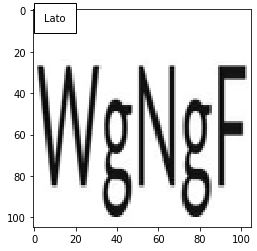

In [35]:
label = rev_conv_label(y[0,0])
fig, ax = plt.subplots(1)
ax.imshow(pil_im, interpolation='nearest', cmap=cm.gray)
ax.text(5, 5, label , bbox={'facecolor': 'white', 'pad': 10})
plt.show()